In [1]:
#  Imports

import numpy      as     np
from   scipy      import stats  as stats
from   matplotlib import pyplot as plt

In [2]:
#  Model independent constants

num_train = int(1e5)
noise_size = 3

In [3]:
#  Model dependent constants
#  Define model PDF

range_min, range_max = 0., 30.
range_width = range_max - range_min
plot_resolution = 0.2

w1, m1, s1 = 0.5, 8., 1.
w2, m2, s2 = 0.5, 14, 5.

N_1 = w1 / (w1 + w2) / (stats.norm.cdf(range_max, m1, s1) - stats.norm.cdf(range_min, m1, s1))
N_2 = w2 / (w1 + w2) / (stats.norm.cdf(range_max, m2, s2) - stats.norm.cdf(range_min, m2, s2))


def true_pdf (x) :
    return N_1*stats.norm.pdf(x, m1, s1) + N_2*stats.norm.pdf(x, m2, s2)

def true_cdf (x) :
    return N_1*stats.norm.cdf(x, m1, s1) + N_2*stats.norm.cdf(x, m2, s2)

In [4]:
#  Func: generate datapoints from arbitrary PDF

def generate_data (num_pnts, resolution=0.01) :
    x = np.linspace(range_min, range_max, 1+int(1./resolution))
    y = true_cdf(x)
    p = np.random.uniform(0, 1, size=(num_pnts,))
    return np.interp(p, y, x)

In [5]:
#  Func: plot datapoints

def plot_points (data, label) :
    x = np.linspace(range_min, range_max, 1000)
    y = true_pdf(x)
    plt.plot(x, y, "--", linewidth=3, c="r", label="True PDF")
    plt.fill_between(x, np.zeros(shape=x.shape), y, color="gray", alpha=0.8)
    h = plt.hist(data, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue", density=True, alpha=0.3, label=label)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("x", size=14, labelpad=15)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=35, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    plt.gca().set_ylim([0, 1.5*max([max(y),max(h[0])])])
    plt.show()

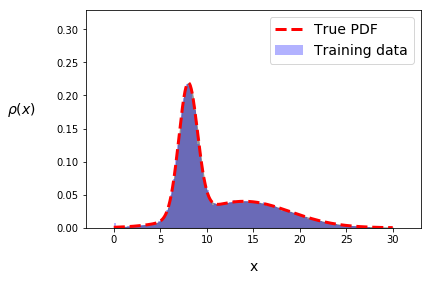

In [6]:
#  Generate  datapoints

train_DS = generate_data(num_train)
plot_points(train_DS, "Training data")

In [11]:
#  Create GAN

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam

d = Sequential(name="Discriminator")
d.add(Dense(20, activation="relu", input_shape=(1,)))
d.add(Dense(20, activation="relu"))
d.add(Dense(20))
d.add(LeakyReLU(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(20, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(20, activation="relu"))
g.add(BatchNormalization())
g.add(Dense(20, activation="relu"))
g.add(BatchNormalization())
g.add(Dense(1, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 20)                420       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 42        
Total params: 922
Trainable params: 922
Non-trainable params: 0
_________________________________________________________________
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output 

In [12]:
#  Func: plot GAN progress

def plot_points_GAN (data, label, epoch, batch_size, d_acc, gan_acc) :
    x = np.linspace(range_min, range_max, 200)
    y = true_pdf(x)
    plt.plot(x, y, "--", linewidth=3, c="r", label="True PDF")
    plt.fill_between(x, np.zeros(shape=x.shape), y, color="gray", alpha=0.8)
    h = plt.hist(data, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue", density=True, alpha=0.3, label=label)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    y_max = 1.5*max([max(y),max(h[0])])
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.84*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.750*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.683*1.1*range_width, 0.61*y_max, f"Batch size: {batch_size}")
    plt.text(range_min+0.780*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    #plt.text(range_min+0.780*(range_max-range_min), 0.47*y_max, r"$\epsilon_{\rm GAN}$: "+f"{int(100.*gan_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    plt.savefig(f"out/1D_GAN_test/Train_epoch{epoch}.png", dpi=96)
    plt.show()

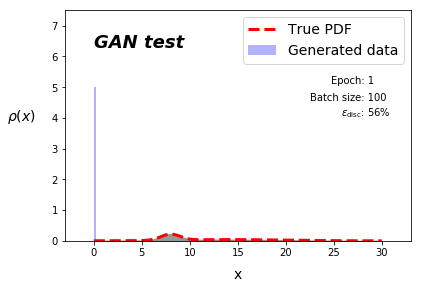

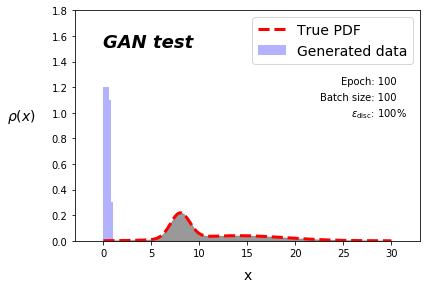

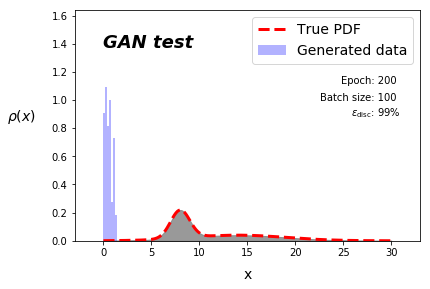

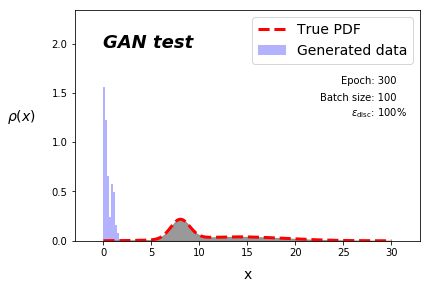

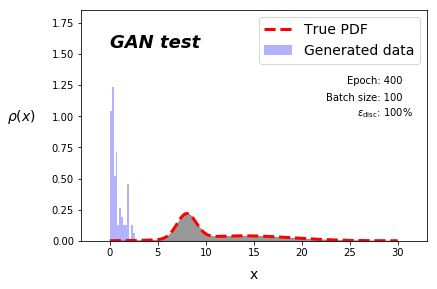

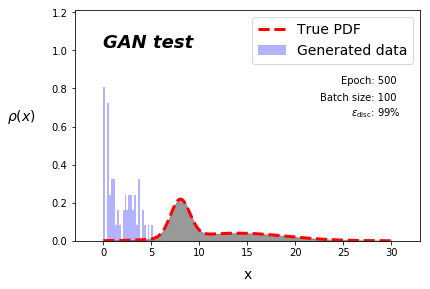

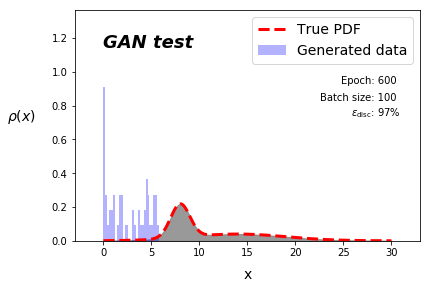

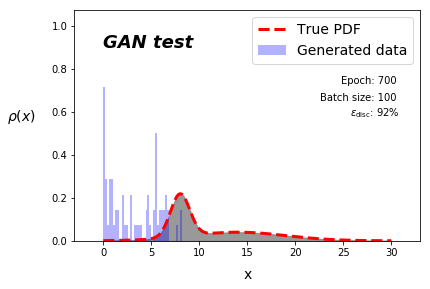

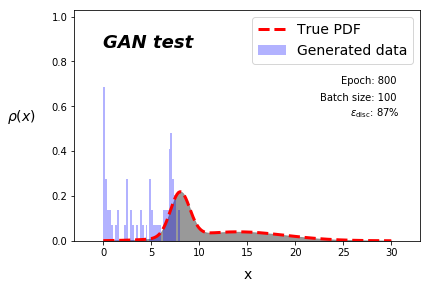

In [ ]:
#  Train GAN

epochs     = 10000
batch_size = 100
max_D_itrs_per_G_itr_e70 = 4
max_D_itrs_per_G_itr_e52 = 3

train_median, train_std = np.median(train_DS), np.std(train_DS)
quantiles = np.array([.25, .75])
train_quantiles = np.quantile(train_DS, quantiles) - train_median

def update_batch_size (gen_DS) :
    global batch_size
    gen_median, gen_std = np.median(gen_DS.flatten()), np.std(gen_DS.flatten())
    if np.fabs((gen_median-train_median)/train_std) > 1./np.sqrt(batch_size) : return
    if np.fabs((gen_std/train_std)-1) > 1./np.sqrt(batch_size) : return
    '''if batch_size > 200 :
        gen_quantiles = np.quantile(gen_DS, quantiles) - gen_median
        for gen_q, train_q in zip(gen_quantiles, train_quantiles) :
            if np.fabs((gen_q/train_q)-1) > 1./np.sqrt(batch_size) : return'''
    batch_size = min(100+batch_size, num_train)
    
epochs_saved = []
for e in range(epochs) :
    noise  = np.random.normal(size=(batch_size, noise_size))
    batch_DS = train_DS[np.random.randint(0, len(train_DS), batch_size)].reshape(batch_size, 1)
    gen_DS   = g.predict(noise)
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)
    num_itr = 0
    while num_itr < max_D_itrs_per_G_itr_e70 and d_acc < 0.7 :
        d_loss, d_acc = d.train_on_batch(X, Y)
        num_itr = num_itr + 1
    while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
        d_loss, d_acc = d.train_on_batch(X, Y)
        num_itr = num_itr + 1
        
    noise  = np.random.normal(size=(batch_size, noise_size))
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = np.random.normal(size=(batch_size, noise_size))
        gen_DS = g.predict(noise)
        plot_points_GAN(gen_DS, f"Generated data", 
                    epoch=e+1, 
                    batch_size=batch_size, 
                    d_acc=d.evaluate(X, Y, verbose=0)[1], 
                    gan_acc=gan.evaluate(noise, real_label, verbose=0)[1])
        update_batch_size(gen_DS)
        epochs_saved.append(e+1)


In [ ]:
#  Combine GAN plots into a gif showing the training process

import subprocess

delay = 50

subprocess.call(["convert", "-delay", str(delay)]
                + [f"out/1D_GAN_test/Train_epoch{e}.png" for e in epochs_saved]
                + ["out/1D_GAN_test/GAN_training.gif" for i in range(6)] )
